In [1]:
import os
from pprint import pprint
import numpy as np
from dicomhd import io as dhd_io
from medpy.io import load as load_lbl
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# load data
path_to_data = '../../../data/HLH-Joe/input/compelete/groundglass-133641-Joe-2_reviewed_1-93/'
path_to_lbl = '../../../data/HLH-Joe/output/complete/groundglass-133641-Joe-2_reviewed_1-275/annotation.gipl'
images = dhd_io.read_series(path_to_data)
labels, label_header = load_lbl(path_to_lbl)
labels = np.swapaxes(labels,0,2)
print('image dimension:', images.shape)
print('label dimesion:', labels.shape)


image dimension: (340, 512, 512)
label dimesion: (340, 512, 512)


In [8]:
labels.max()
print(images.pixel_data.min(),images.pixel_data.max())

-1024 3071


In [203]:
#slice with annotations
idx = [] # slices with annoatations
for i in range(labels.shape[0]):
    if labels[i,:,:].sum() != 0:
        idx.append(i)
print(f' From this image {len(idx)} layer has annoations')

 From this image 47 layer has annoations


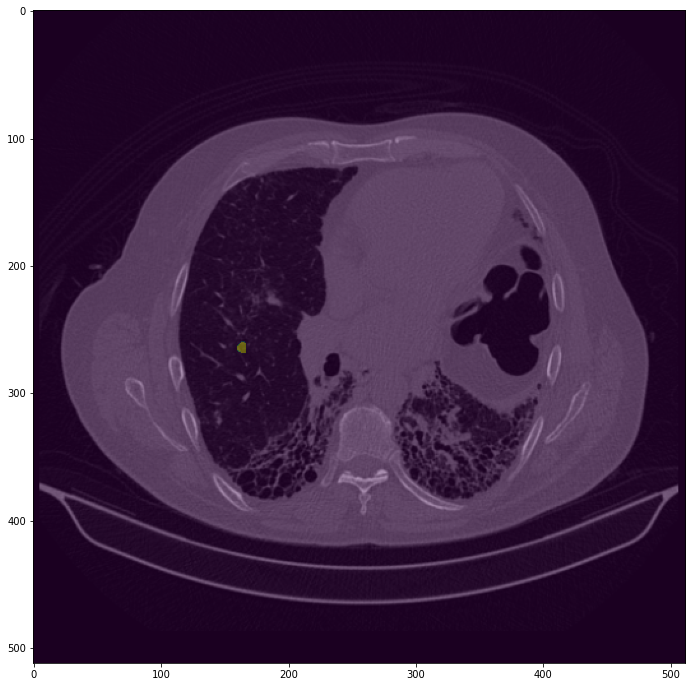

In [174]:
# dispaly image and annoation
plt.figure(1, figsize = (12,12))
i = idx[7]
# i = 20
plt.imshow(images.pixel_data[i,:,:], cmap = 'gray')
plt.imshow(labels[i,:,:], alpha=0.4)


In [169]:
print(label_header.get_voxel_spacing())
print(label_header.spacing)


(0.8378850221633911, 0.8378850221633911, 1.04315185546875)
(0.8378850221633911, 0.8378850221633911, 1.04315185546875)


In [173]:
mask = labels[idx,:,:] > 0
mask.sum(axis=1).sum(axis=1)



array([257, 257, 257, 257, 257, 257,  52,  52,  52,  52,  52,  52,  83,
        83,  83,  83,  83,  83, 125, 125, 125, 125, 125, 360, 235, 235,
       235, 235, 235, 167, 167, 167, 167, 167, 167, 149, 149, 149, 149,
       528, 528, 385, 385, 385, 385])

In [ ]:
# read all labeld images from directory and generate label patches
path_to_lbl = '../../../data/HLH-Joe/output/complete/'    
filenames = sorted([f for f in os.listdir(path_to_lbl)])
filenames.remove('.DS_Store')
annotation_summary = []
for f in filenames:
    file_path = os.path.join(path_to_lbl, f)
    file_path = os.path.join(file_path, 'annotation.gipl')
    labels, label_header = load_lbl(file_path)
    labels = np.swapaxes(labels,0,2)
    if labels.sum() > 0:
        idx = [] # slices with annoatations
        for i in range(labels.shape[0]):
            if labels[i,:,:].sum() != 0:
                idx.append(i)
        mask = labels[idx,:,:] > 0     
        annotation_summary.append(mask.sum(axis=1).sum(axis=1).max())
        
    

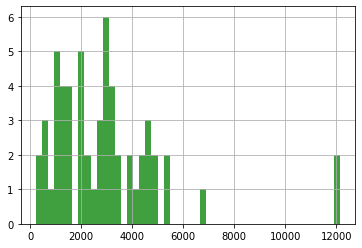

In [103]:
fig = plt.hist(annotation_summary, 50, density=False, facecolor='g', alpha=0.75)
plt.grid(True)
plt.show()

In [3]:
#Fucntion to extract image and label pathces
def extract_3D_patch(images):
    # convert image data to tensor
    imgs = np.expand_dims(images, [0, -1])
    t_imgs = tf.convert_to_tensor(imgs, dtype='float32')
    # Extract voulm patches: 30x48x48
    t_patches = tf.extract_volume_patches(
        t_imgs,
        ksizes=[1, 30, 48, 48, 1],
        strides=[1, 15, 24, 24, 1],
        padding='SAME'
    )
    img_patches = tf.reshape(t_patches, (-1 ,30, 48, 48, 1))
   
    return img_patches


In [4]:
#function to extract pathces with annoations
def extract_patch_labels(t_lbl_patches, method='max'):
    if method == 'max':
        t_patch_labels = tf.reduce_max(t_lbl_patches, axis=[1,2,3,4])
    elif method == 'center':
        raise NotImplementedError
    else:
        raise ValueError('Invalid label extraction method!')
    
    return t_patch_labels

def extract_annotated_patch(t_img_patches,t_lbl_patches):
    # get patch labels
    t_patch_labels = extract_patch_labels(t_lbl_patches, 'max')
    mask = t_patch_labels > 0
    t_lbl_patches_with_annotation = tf.boolean_mask(t_lbl_patches, mask, axis=0)
    t_patch_img_with_annotation = tf.boolean_mask(t_img_patches, mask, axis=0)
    t_patch_lbl_with_annotation = tf.boolean_mask(t_patch_labels, mask, axis = 0)
    return t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation

In [5]:
#Extract patches
t_img_patches = extract_3D_patch(images.pixel_data)
t_lbl_patches = extract_3D_patch(labels)
print(f'dimesion of image patches: {t_img_patches.shape}')
print(f'dimesion of label patches: {t_lbl_patches.shape}')

dimesion of image patches: (12584, 30, 48, 48, 1)
dimesion of label patches: (12584, 30, 48, 48, 1)


In [1]:
display exmaple patches
img_p = np.array(t_patch_img_with_annotation)
s_img = img_p[2,29,:,:,0]

img_l = np.array(t_patch_labels_with_annotation)
l_img = img_l[2,29,:,:,0]
plt.imshow(s_img, cmap='gray')
plt.imshow(l_img, alpha=0.4)

SyntaxError: invalid syntax (<ipython-input-1-fe924536f349>, line 1)

In [ ]:
# nm of classes
path_to_data = '../../data/HLH-Joe/input/unzip/'
filename = [f.split("-", 1)[0] for f in os.listdir(path_to_data)]
filename.remove('.DS_Store')
labels = list(set(filename))
nm_of_cls = len(labels)
print(f'There are {nm_of_cls} class in this set:')
for lbl in labels:
    print(f'The class {lbl} has {filename.count(lbl)} samples')
    

In [ ]:
# read all images from directory and generate image patches
path_to_data = '../../data/HLH-Joe/input/unzip/'
filenames = sorted([f for f in os.listdir(path_to_data)])
filenames.remove('.DS_Store')
list_t_img_patches = []
for f in filenames:
    file_path = os.path.join(path_to_data, f)
    print(file_path)
    images = dhd_io.read_series(file_path)
    print('image dimension:', images.pixel_data.shape)
    t_img_patches = extract_3D_patch(images.pixel_data)
    list_t_img_patches.append(t_img_patches)
    print(f'dimesion of image patches: {t_img_patches.shape}')
    
# stack all patches
t_stack_img_patches = tf.concat(list_t_img_patches, axis=0)
print(f'shape of stack images: {t_stack_img_patches.shape}')

../../data/HLH-Joe/input/unzip/Honeycomb-013710-Joe_reviewed_1-279
image dimension: (385, 512, 512)
dimesion of image patches: (12584, 30, 48, 48, 1)
../../data/HLH-Joe/input/unzip/Honeycomb-068c5d-Joe_reviewed_1-281
image dimension: (234, 512, 512)
dimesion of image patches: (7744, 30, 48, 48, 1)
../../data/HLH-Joe/input/unzip/Honeycomb-5a2c14-Joe_reviewed_1-284
image dimension: (971, 512, 512)
dimesion of image patches: (31460, 30, 48, 48, 1)
../../data/HLH-Joe/input/unzip/Honeycomb-695c19-Joe_reviewed_1-290
image dimension: (361, 512, 512)
dimesion of image patches: (12100, 30, 48, 48, 1)
../../data/HLH-Joe/input/unzip/Honeycomb-92a845-Joe_reviewed_1-285
image dimension: (245, 512, 512)
dimesion of image patches: (8228, 30, 48, 48, 1)
../../data/HLH-Joe/input/unzip/Honeycomb-a09d21-Joe_reviewed_1-286
image dimension: (407, 512, 512)
dimesion of image patches: (13552, 30, 48, 48, 1)
../../data/HLH-Joe/input/unzip/Honeycomb-b58c2f-Joe_reviewed_1-282
image dimension: (386, 512, 747)
di

In [144]:
# read all labeld images from directory and generate label patches

path_to_data = '../../data/HLH-Joe/input/unzip/'
filenames = sorted([f for f in os.listdir(path_to_data)])
filenames.remove('.DS_Store')
list_t_img_patches = []
# 
path_to_lbl = '../../../data/HLH-Joe/output/complete/'    
filenames = sorted([f for f in os.listdir(path_to_lbl)])
filenames.remove('.DS_Store')
list_t_lbl_patches = []
for f in filenames:
    file_path = os.path.join(path_to_lbl, f)
    file_path = os.path.join(file_path, 'annotation.gipl')
    labels, label_header = load_lbl(file_path)
    labels = np.swapaxes(labels,0,2)
    # get plane indices with annotation
    break
    print('label dimesion:', labels.shape)
    t_lbl_patches = extract_3D_patch(labels)
    list_t_lbl_patches.append(t_lbl_patches)
    print(f'dimesion of label patches: {t_lbl_patches.shape}')
    
# t_stack_lbl_patches = tf.concat(list_t_lbl_patches, axis=0)
# print(f'shape of stack labels: {t_stack_lbl_patches.shape}')

In [145]:
idx_with_annotation = np.ma.where(labels.sum(axis=(1,2)) > 0)[0]
labels=labels[idx_with_annotation.min():idx_with_annotation.max()+1, ...]


In [147]:
labels.shape

(196, 512, 512)

In [ ]:
#extract annoated patches
t_patch_img_with_annotation, t_lbl_patches_with_annotation, t_patch_lbl_with_annotation = \
    extract_annotated_patch(t_stack_img_patches, t_stack_lbl_patches)
t_patch_img_with_annotation = tf.squeeze(t_patch_img_with_annotation, axis=4)
print(f'dimesion of annoated patch labels: {t_patch_img_with_annotation.shape}')
t_lbl_patches_with_annotation = tf.squeeze(t_lbl_patches_with_annotation, axis=4)
print(f'dimesion of annoated patch labels: {t_lbl_patches_with_annotation.shape}')

In [ ]:
print(f'dimesion of annoated image patches: {t_patch_img_with_annotation.shape}')
print(f'dimesion of annoated label patches: {t_lbl_patches_with_annotation.shape}')
print(f'dimesion of annoated patch labels: {t_patch_lbl_with_annotation.shape}')

In [ ]:
img_p = np.array(t_patch_img_with_annotation)
s_img = img_p[1240,29,:,:]

img_l = np.array(t_lbl_patches_with_annotation)
l_img = img_l[1240,29,:,:]
plt.imshow(s_img, cmap='gray')
plt.imshow(l_img, alpha=0.4)
l_img.max()


In [ ]:
#dataset loader
dataset = tf.data.Dataset.from_tensor_slices((t_patch_img_with_annotation, t_patch_lbl_with_annotation))
dataset.element_spec

### Draft


In [ ]:
t_patch_img_with_annotation, t_patch_labels_with_annotation = extractAnnotatedpatch(t_img_patches, t_lbl_patches)
print(f'dimesion of annoated image patches: {t_patch_img_with_annotation.shape}')
print(f'dimesion of annoated label patches: {t_patch_img_with_annotation.shape}')

In [ ]:
#Extract patches with annotations by maximum
t_patch_labels = tf.reduce_max(t_lbl_patches, axis=[1,2,3,4])
mask = t_patch_labels > 0
t_patch_labels_with_annotation = tf.boolean_mask(t_lbl_patches, mask, axis=0)
t_patch_img_with_annotation = tf.boolean_mask(t_img_patches, mask, axis=0)
print(f'dimesion of annoated image patches: {t_patch_img_with_annotation.shape}')
print(f'dimesion of annoated label patches: {t_patch_img_with_annotation.shape}')

In [ ]:
#show class label
labels[idx[1],:,:].max()

In [ ]:
# path_to_data = '../../data/HLH-Joe/output/unzip/'
# filenames = sorted([f for f in os.listdir(path_to_data)])
# filenames.remove('.DS_Store')
# filenames
# file_path = os.path.join(path_to_data, filnames[1])
# for f in filenames[:3]:
#     file_path = os.path.join(path_to_data, f)
#     print(file_path)
#     images = dhd_io.read_series(file_path)
#     print(images.pixel_data.shape)

In [ ]:
# lbl_patches[:, 
#     int(lbl_patches.shape[1]/2), 
#     int(lbl_patches.shape[2]/2), 
#     int(lbl_patches.shape[3]/2), 
#     0]

In [ ]:
img_p = np.array(img_patches)
s_img = img_p[345,29,:,:,0]
plt.imshow(s_img, cmap='gray')

# lbl_p = np.array(lbl_patches)
# s_img = lbl_p[670,23,:,:,0]
# plt.imshow(s_img, cmap='gray')

In [ ]:
# check lbl pathces for annations
data = lbl_patches[0,:,:,:,0]
c_patch = np.array(crop3Dcenter(data, s2=[14,24,24]))
c_patch.shape
# idx = []
# for i in range(c_patch.shape[0]):
#     if c_patch[i,:,:].sum() != 0:
#         idx.append(idx)
# print(len(idx))

In [ ]:
# Find the patches centroid
def crop3Dcenter(data, s2):
    """ crops 3D volume with size s2 from the center
    #args:
        data: 30x48x48 3D volume patch
        s2: ouput volume size after cropping
    returns: Center cropped 3D volume data"""
    s = data.shape
    cr = [int((s[i]-j)/2) for i,j in enumerate(s2)]
    
    return data[cr[0]:-cr[0],cr[1]:-cr[1],cr[2]:-cr[2]]

In [ ]:
# Extract voulm patches: 30x48x48
t_patches = tf.extract_volume_patches(
    t_imgs,
    ksizes=[1, 30, 48, 48, 1],
    strides=[1, 30, 48, 48, 1],
    padding='SAME'
)
print(t_patches.shape)



In [ ]:
#Reshape patch
tf.reshape(t_patches[0, 0, 0, 0, :], (30, 48, 48)).shape
tf.reshape(t_patches, (-1 ,30, 48, 48, 1)).shape

In [ ]:
n = 10
# images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100
images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]


# We generate two outputs as follows:
# 1. 3x3 patches with stride length 5
# 2. Same as above, but the rate is increased to 2
tf.image.extract_patches(images=images,
                       sizes=[1, 3, 3, 1],
                       strides=[1, 5, 5, 1],
                       rates=[1, 1, 1, 1],
                       padding='VALID')

